In [11]:
import torch
from d2l import torch as d2l
from torch import nn
%matplotlib inline

In [12]:
# 增加L2惩罚系数来做权重衰减的主要好处是：
#   防止过拟合，模型更简洁（w的更多分量为0），提高泛化能力，训练更平稳

# 和8中一样，根据多项式创建数据
# 设定初始参数
n_train,n_test,num_inputs,batch_size = 20,100,200,5
true_w,true_b = torch.ones((num_inputs,1))*0.01,0.05
train_data = d2l.synthetic_data(true_w,true_b,n_train)
train_iter = d2l.load_array(train_data,batch_size)
test_data = d2l.synthetic_data(true_w,true_b,n_test)
test_iter = d2l.load_array(test_data,batch_size,is_train=False)

In [4]:
# 获取混淆的权重参数，用于初始化wb
def init_params():
    w = torch.normal(0,1,size=(num_inputs,1),requires_grad=True)
    b = torch.zeros(1,requires_grad=True)
    return [w,b]

In [5]:
# 定义l2 平方和*(λ/2) 这里的λ设置为1
def l2_penalty(w):
    return torch.sum(w.pow(2))/2

In [8]:
# 定义训练
def train(lambd):  # 入参是λ，在l2范式定义里写的是1/2，这里相当于乘上λ
    w,b = init_params()
    # lambda 快速定义匿名函数，等价于：
    # def net(X):
    #   return d2l.linreg(X, w, b)
    net,loss = lambda X: d2l.linreg(X,w,b),d2l.squared_loss
    num_epochs,lr = 100,0.003
    animator = d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',xlim=[5,num_epochs],
                                                                             legend=['train','test'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            # 损失函数添加柔性限制 l2范数惩罚项
            l = loss(net(X),y)+lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w,b],lr,batch_size)
        if(epoch+1)%5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的l2范数打印：',torch.norm(w).item())


w的l2范数打印： 12.594120979309082


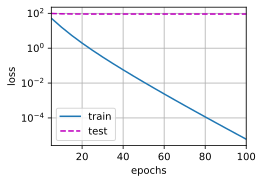

In [9]:
# 不使用正则化的情况
train(lambd=0)
# 结果是验证数据集的误差没有减少，只有训练集误差减少，说明过拟合了，只认识训练数据

w的l2范数打印： 0.35382282733917236


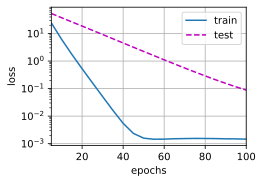

In [10]:
# 使用权重衰减，就是将w向量往0拉，尽量变小整体
train(lambd=3)

In [13]:
def train_concise(wd):  # wd就是惩罚系数
    net = nn.Sequential(nn.Linear(num_inputs,1))
    for param in net.parameters():
        param.data.normal_() # 对模型的所有参数生成正态分布随机数
    loss = nn.MSELoss(reduction='none')
    num_epochs ,lr = 100,0.003
    # 权重衰减（weight_decay）其实就是 L2 正则化的一种形式，通常在损失函数中加上 𝜆∥𝜃∥^2 λ∥θ∥^2 项（其中 
    # θ 是模型参数，𝜆 是惩罚系数）。这可以帮助防止过拟合。
    # 不过，在 torch.optim.SGD 或其他优化器中指定 weight_decay 其实是一个等效的实现方式
    # 在 PyTorch 中，当你设置 weight_decay，优化器会在每次更新权重时，对权重再多 -学习率*λ𝜃
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay':wd},  # wd一般给0.001或者更小，一般不会取到1
        {"params":net[0].bias}]
        ,lr
        )
    # 以上的代码是只对weght做衰减，如果b参数也要，可以这么写
    # torch.optim.SGD(params=net.parameters(),lr=lr,weight_decay=wd)
    animator = d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',
                            xlim=[5,num_epochs],legend=['train','test'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l = loss(net(X),y)
            l.mean().backward()
            trainer.step()
        if(epoch+1)%5 ==0:
            animator.add(epoch+1,
                         (d2l.evaluate_loss(net,train_iter,loss),
                          d2l.evaluate_loss(net,test_iter,loss)))
        print('w的l2范数',net[0].weight.norm().item())



w的l2范数 12.665392875671387


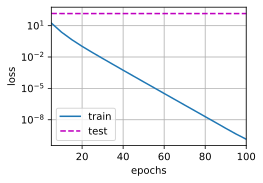

In [14]:
train_concise(0)

w的l2范数 0.01798509620130062


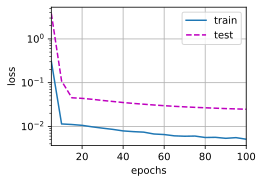

In [16]:
train_concise(30)